In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner
from scipy.optimize import minimize
from multiprocessing import Pool
from ldtk import LDPSetCreator, BoxcarFilter
import model_logic as ml

# --- 1. 設定セクション ---
P_ORBIT = 6.3980420
# Pathを指定
BASE_PATH = " "
OBS_CONFIGS = [
    {"path": "TOI-560b_231223_sinistro_i_c145_r16.csv", "band": "i", "t0_init": 0.744074, "t_offset": 2460302},
    {"path": "TOI-560b_240226_sinistro_i_c145_r18.csv", "band": "i", "t0_init": 0.724494, "t_offset": 2460366},
]

INIT_VALS = {
    'k': 0.03932, 'k_err': 0.00064,
    'ln_a': 2.9947,
    'T14': 0.08925, 'T14_err': 0.001167
}
N_OBS = len(OBS_CONFIGS)

In [3]:
# --- 2. 実行ブロック ---
# データの読み込み
all_time, all_flux, all_flux_err, all_bands = [], [], [], []
for obs in OBS_CONFIGS:
    df = pd.read_csv(os.path.join(BASE_PATH, obs["path"]))
    all_time.append(df.iloc[:,0].values - obs['t_offset'])
    all_flux.append(df.iloc[:,1].values)
    all_flux_err.append(df.iloc[:,2].values)
    all_bands.append(obs['band'])

# イベントマッピング (共通t0の管理)
# t_initialは各イベントで最初に読み込まれた値にしている
unique_offsets = []
event_map = []
t0_initials = []
for i, obs in enumerate(OBS_CONFIGS):
    off = obs["t_offset"]
    if off not in unique_offsets:
        unique_offsets.append(off)
        t0_initials.append(obs["t0_init"])
    event_map.append(unique_offsets.index(off))

N_EVENTS = len(unique_offsets)
print(f"Total observations: {N_OBS} | Unique transit events (shared t0): {N_EVENTS}")

# LDC計算
def get_ldc():
    f_map = {'i': [700, 820], 'r': [550, 700]}
    res = {}
    for b, w in f_map.items():
        sc = LDPSetCreator(teff=(4511, 110), logg=(4.62, 0.12), z=(0, 0.09), filters=[BoxcarFilter(b, w[0], w[1])])
        qc, qe = sc.create_profiles().coeffs_qd(do_mc=True, n_mc_samples=10000)
        res[b] = {"mean": qc[0], "std": qe[0]}
    return res
LDC_REF = get_ldc()

# Stage 1: BICによる次数判定
print("Stage 1: Determining best polynomial degrees...")
best_degrees = []
print(f"{'Data Index':<12} | {'BIC (0-deg)':<12} | {'BIC (1-deg)':<12} | {'BIC (2-deg)':<12} | {'Best Degree'}")
print("-" * 80)

for i in range(N_OBS):
    bics = []
    for deg in [0, 1, 2]:
        def obj(p):
            t0, j0 = p
            geom = ml.calc_transit_params(INIT_VALS['k'], INIT_VALS['ln_a'], INIT_VALS['T14'], P_ORBIT)
            if geom is None or j0 < 0: return 1e15
            import pytransit
            tm = pytransit.QuadraticModel()
            tm.set_data(all_time[i])
            mtr = tm.evaluate_ps(INIT_VALS['k'], LDC_REF[all_bands[i]]["mean"], t0, P_ORBIT, geom[0], geom[1], 0, 0)
            c = np.polyfit(all_time[i] - t0, all_flux[i] / mtr, deg)
            sig2 = all_flux_err[i]**2 + j0**2
            ll = -0.5 * np.sum((all_flux[i] - mtr * np.polyval(c, all_time[i]-t0))**2 / sig2 + np.log(2*np.pi*sig2))
            return -ll
        sol = minimize(obj, [OBS_CONFIGS[i]["t0_init"], 0.001], method='Nelder-Mead')
        bic_val = 2 * sol.fun + (2 + deg + 1) * np.log(len(all_flux[i]))
        bics.append(bic_val)
    best_deg = np.argmin(bics)
    best_degrees.append(best_deg)
    print(f"Dataset {i:<3} | {bics[0]:>12.2f} | {bics[1]:>12.2f} | {bics[2]:>12.2f} | {best_deg}")

# Stage 2: MCMC
# パラメータ: [k, ln_a, T14, u1i, u2i, u1r, u2r] (7) + t0s (N_EVENTS) + jitters (N_OBS)
init_p = [INIT_VALS['k'], INIT_VALS['ln_a'], INIT_VALS['T14'], 
            LDC_REF['i']['mean'][0], LDC_REF['i']['mean'][1],
            LDC_REF['r']['mean'][0], LDC_REF['r']['mean'][1]]
init_p += t0_initials
init_p += [0.001] * N_OBS

n_dim = len(init_p)
n_walkers = 100
steps= 5000
pos = init_p + 1e-5 * np.random.randn(n_walkers, n_dim)
mcmc_args = (N_OBS, N_EVENTS, event_map, all_time, all_flux, all_flux_err, all_bands, LDC_REF, INIT_VALS, best_degrees, P_ORBIT)

print(f"Stage 2: Starting MCMC with {n_dim} dimensions...")
with Pool() as pool:
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, ml.log_posterior, pool=pool, args=mcmc_args)
    sampler.run_mcmc(pos, steps, progress=True)

Total observations: 2 | Unique transit events (shared t0): 2
Stage 1: Determining best polynomial degrees...
Data Index   | BIC (0-deg)  | BIC (1-deg)  | BIC (2-deg)  | Best Degree
--------------------------------------------------------------------------------
Dataset 0   |     -5684.27 |     -5706.53 |     -5702.64 | 1
Dataset 1   |     -4659.45 |     -4658.51 |     -4652.23 | 0
Stage 2: Starting MCMC with 11 dimensions...


100%|██████████| 5000/5000 [02:01<00:00, 41.02it/s]


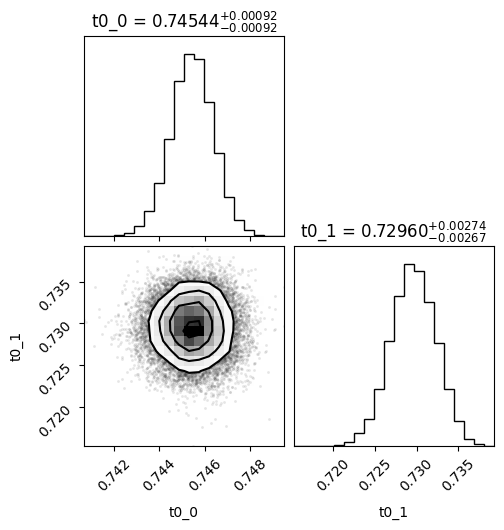

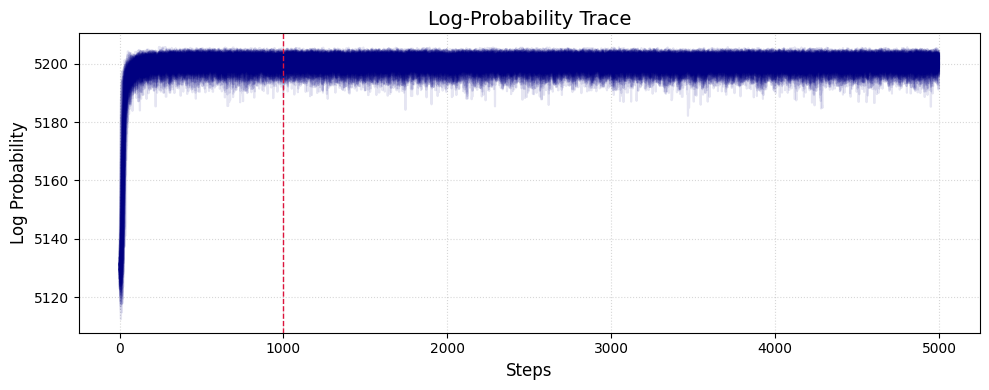

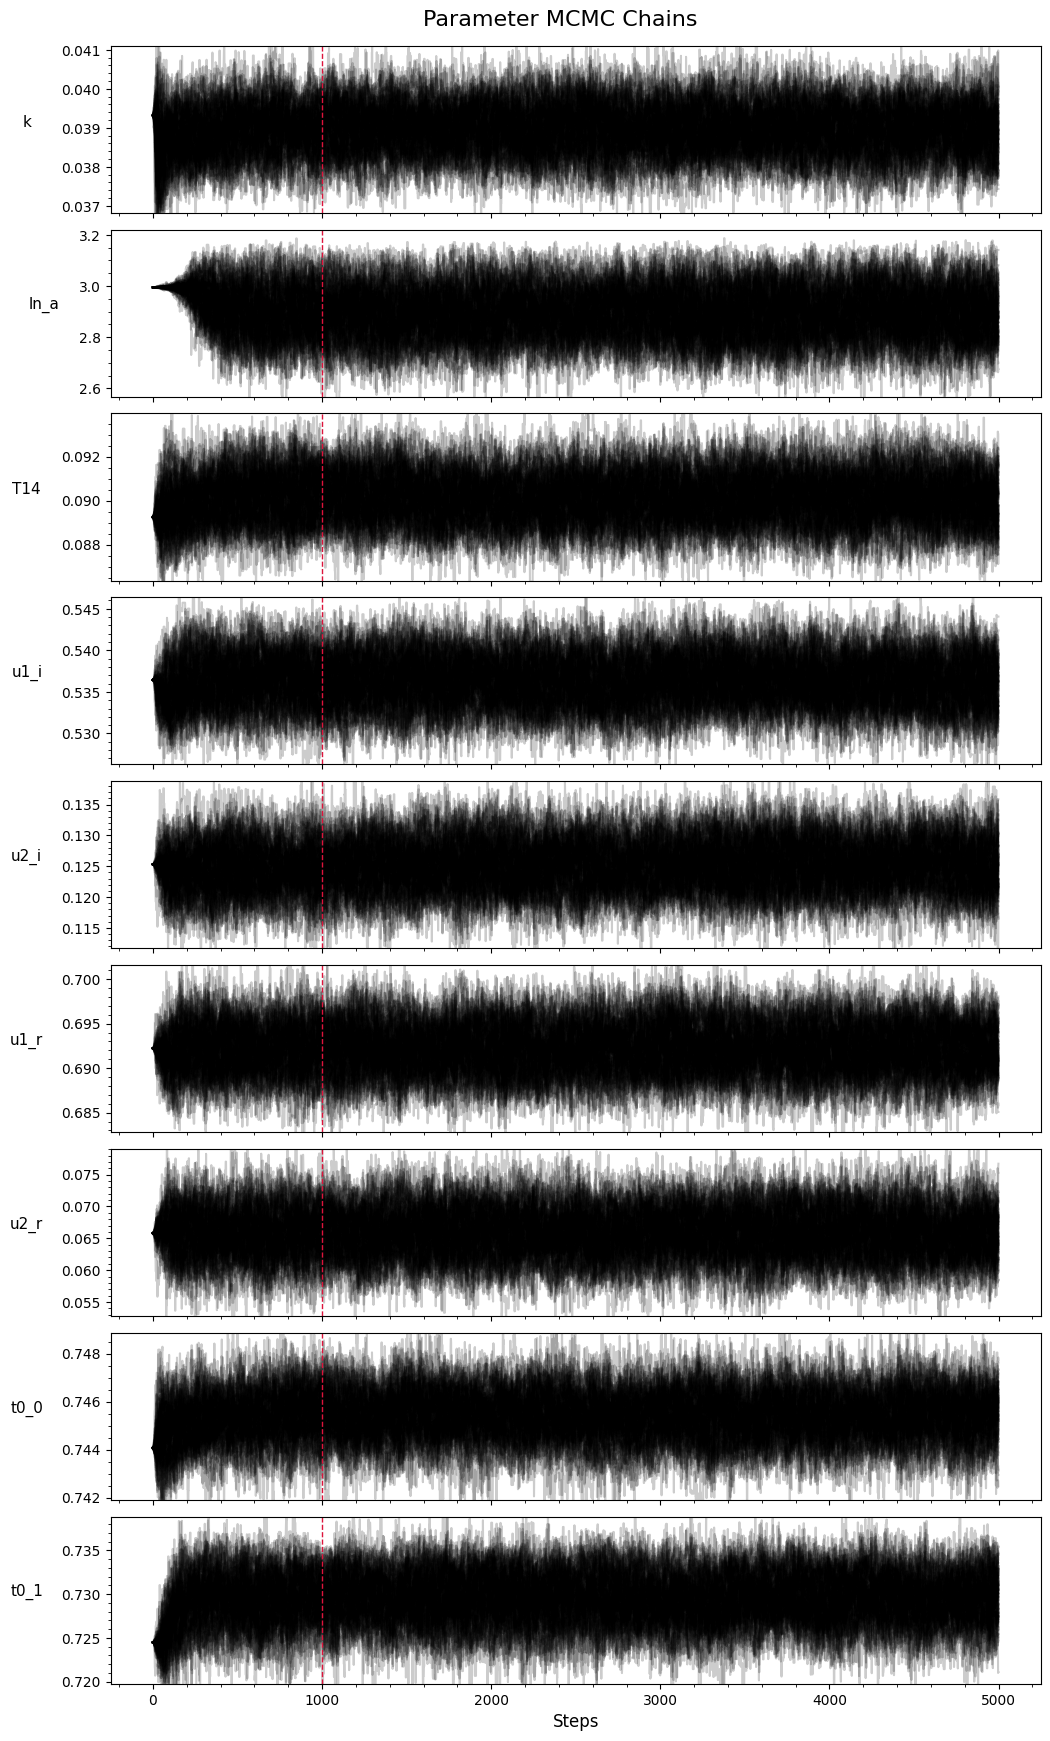

In [4]:
# プロット処理 (t0のみ)
discard = 1000
samples = sampler.get_chain(discard=discard, thin=15, flat=True)
t0_samples = samples[:, 7 : 7 + N_EVENTS]
t0_labels = [f"t0_{i}" for i in range(N_EVENTS)]
fig = corner.corner(t0_samples, labels=t0_labels, show_titles=True, title_fmt='.5f')
plt.show()

# 1. 対数尤度の推移 (Convergence)
log_prob = sampler.get_log_prob()
plt.figure(figsize=(10, 4))
plt.plot(log_prob, alpha=0.1, color='navy')
plt.xlabel('Steps', fontsize=12)
plt.ylabel('Log Probability', fontsize=12)
plt.title('Log-Probability Trace', fontsize=14)
plt.axvline(discard, color='crimson', linestyle='--', lw=1)
plt.grid(True, which='both', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 2. パラメータのトレースプロット ---
n_phys = 7
n_plot = n_phys + N_EVENTS
samples_chain = sampler.get_chain()
labels_plot = ["k", "ln_a", "T14", "u1_i", "u2_i", "u1_r", "u2_r"] + [f"t0_{i}" for i in range(N_EVENTS)]

fig, axes = plt.subplots(n_plot, 1, figsize=(12, 2 * n_plot), sharex=True)


plt.subplots_adjust(hspace=0.1, top=0.96, bottom=0.05) 

for i in range(n_plot):
    ax = axes[i]
    ax.plot(samples_chain[:, :, i], alpha=0.2, color='black', rasterized=True)
    ax.set_ylabel(labels_plot[i], fontsize=11, rotation=0, labelpad=25)
    
    ax.axvline(discard, color='crimson', linestyle='--', lw=1)
    ax.minorticks_on()
    
    y_min, y_max = np.percentile(samples_chain[discard:, :, i], [0.5, 99.5])
    ax.set_ylim(y_min - 0.2*(y_max-y_min), y_max + 0.2*(y_max-y_min))

axes[-1].set_xlabel('Steps', fontsize=12)

plt.suptitle('Parameter MCMC Chains', fontsize=16, y=0.98) 

plt.show()

In [5]:
# --- 1. Best-fit (最大尤度) パラメータの抽出 ---

# flat=True で取得したサンプルと対数尤度を使用
flat_samples = sampler.get_chain(discard=10, thin=15, flat=True)
flat_log_prob = sampler.get_log_prob(discard=10, thin=15, flat=True)

# 対数尤度が最大となるインデックスを特定
best_idx = np.argmax(flat_log_prob)
theta_best = flat_samples[best_idx]

print(f"Maximum Log-Probability: {flat_log_prob[best_idx]:.4f}")
print("-" * 30)

# 統計値の出力 (Best-fit値をメインに、誤差は16/84パーセンタイルから算出)
labels_to_show = ["k", "ln_a", "T14", "u1_i", "u2_i", "u1_r", "u2_r"]
labels_to_show += [f"t0_event{i}" for i in range(N_EVENTS)]

print(f"{'Parameter':<12} | {'Best-fit':<12} | {'Lower Err':<10} | {'Upper Err':<10} | {'RMS Err (Rep)':<12}")
print("-" * 80)

for i in range(len(labels_to_show)):
    best_val = theta_best[i]
    
    # 16, 50, 84 パーセンタイルから上下の誤差を算出
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    minus_err = mcmc[1] - mcmc[0]
    plus_err = mcmc[2] - mcmc[1]
    
    # 誤差の二乗平均 (RMS) を計算
    rms_err = np.sqrt((minus_err**2 + plus_err**2) / 2)
    
    # 出力 (時刻は桁数が多いため .6f, その他は適切な精度で)
    print(f"{labels_to_show[i]:<12} | {mcmc[1]:>12.6f} | {minus_err:>10.6f} | {plus_err:>10.6f} | {rms_err:>12.6f}")

print("-" * 80)

Maximum Log-Probability: 5205.6813
------------------------------
Parameter    | Best-fit     | Lower Err  | Upper Err  | RMS Err (Rep)
--------------------------------------------------------------------------------
k            |     0.038971 |   0.000604 |   0.000580 |     0.000592
ln_a         |     2.903291 |   0.095745 |   0.091293 |     0.093545
T14          |     0.090092 |   0.001050 |   0.001058 |     0.001054
u1_i         |     0.536303 |   0.002804 |   0.002826 |     0.002815
u2_i         |     0.125067 |   0.003732 |   0.003752 |     0.003742
u1_r         |     0.692160 |   0.002594 |   0.002698 |     0.002647
u2_r         |     0.065857 |   0.003563 |   0.003615 |     0.003589
t0_event0    |     0.745412 |   0.000938 |   0.000926 |     0.000932
t0_event1    |     0.729492 |   0.002761 |   0.002766 |     0.002763
--------------------------------------------------------------------------------


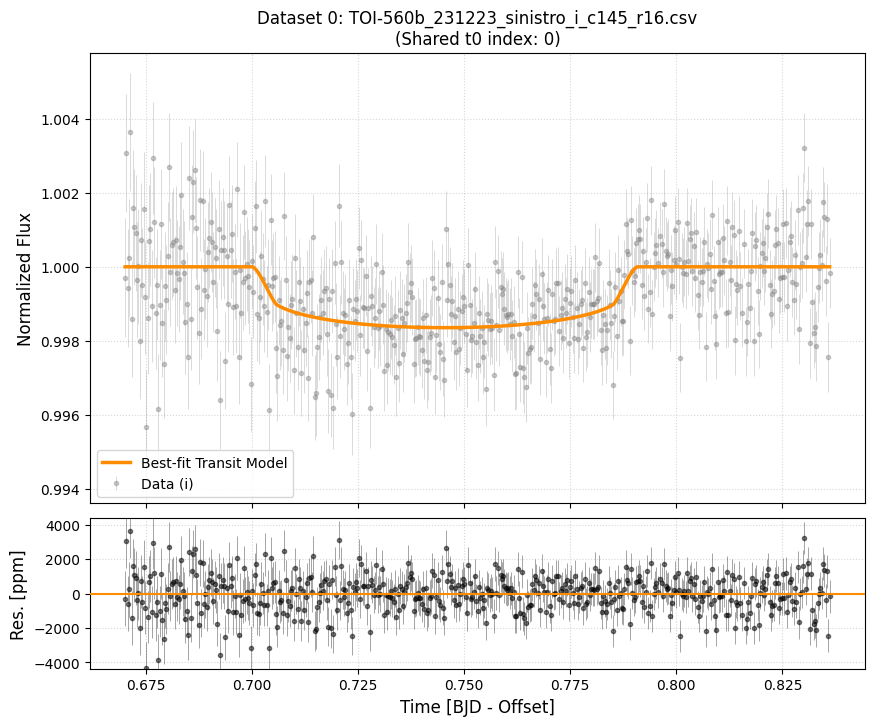

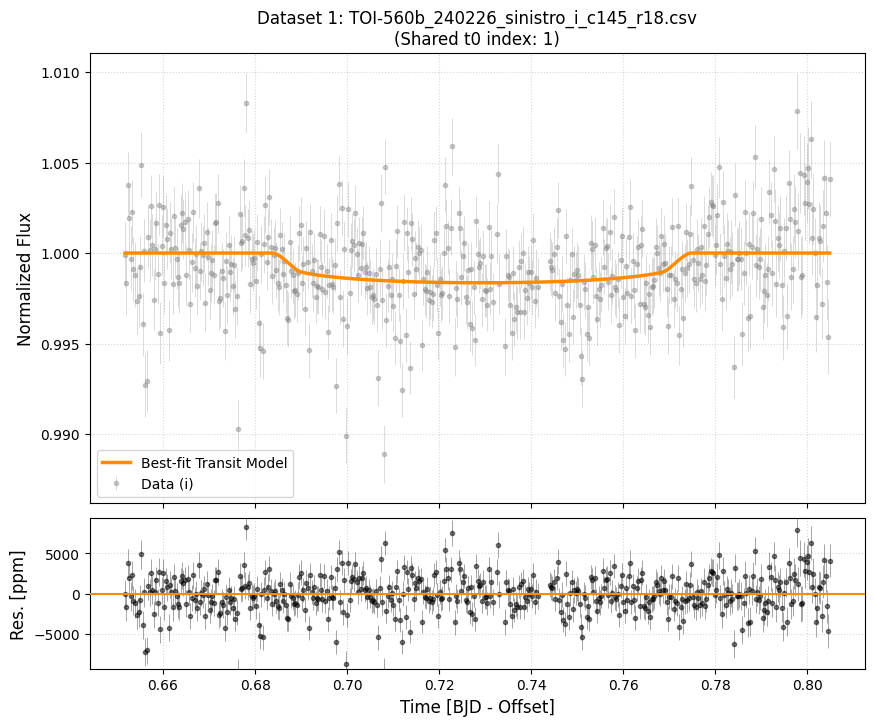

In [6]:
# --- 2. Best-fit モデルを用いた可視化 ---

# 最大尤度推定値 (theta_best) をアンパック
# n_obs, n_events を明示的に指定
k_b, ln_a_b, T14_b, ldc_b, t0s_b, jitters_b = ml.unpack_params(theta_best, N_OBS, N_EVENTS)
res_geom = ml.calc_transit_params(k_b, ln_a_b, T14_b, P_ORBIT)

if res_geom is None:
    print("Warning: Best-fit parameters are non-physical. Check MCMC convergence.")
else:
    a_b, inc_b = res_geom

    for i in range(N_OBS):
        # 図の構成設定
        fig = plt.figure(figsize=(10, 8))
        gs = plt.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)
        ax0 = fig.add_subplot(gs[0])
        ax1 = fig.add_subplot(gs[1], sharex=ax0)

        # データの取得
        t, f, e = all_time[i], all_flux[i], all_flux_err[i]
        band = all_bands[i]
        
        # event_map を使用して共通の t0 を特定
        t0_obs = t0s_b[event_map[i]]

        # 理論モデルの計算
        import pytransit
        tm = pytransit.QuadraticModel()
        tm.set_data(t)
        # 観測点でのトランジットモデル
        mtr = tm.evaluate_ps(k_b, ldc_b[band], t0_obs, P_ORBIT, a_b, inc_b, 0, 0)
        
        # 多項式デトレンドの再計算
        # Stage 1 で決定した次数 (best_degrees[i]) を使用
        c = np.polyfit(t - t0_obs, f / mtr, best_degrees[i])
        trend = np.polyval(c, t - t0_obs)
        
        # トレンド補正後のフラックス (正規化)
        f_detrended = f / trend

        # --- 上段: Transit Fit Plot ---
        # 観測データ点
        ax0.errorbar(t, f_detrended, yerr=e, fmt='o', color='gray', markersize=3, 
                     alpha=0.4, label=f'Data ({band})', capsize=0, elinewidth=0.5)
        
        # 高解像度モデル曲線 (描画用)
        t_fine = np.linspace(t.min(), t.max(), 1000)
        tm_fine = pytransit.QuadraticModel()
        tm_fine.set_data(t_fine)
        mtr_fine = tm_fine.evaluate_ps(k_b, ldc_b[band], t0_obs, P_ORBIT, a_b, inc_b, 0, 0)
        ax0.plot(t_fine, mtr_fine, color='darkorange', lw=2.5, label='Best-fit Transit Model', zorder=10)
        
        ax0.set_ylabel('Normalized Flux', fontsize=12)
        ax0.set_title(f'Dataset {i}: {OBS_CONFIGS[i]["path"]}\n(Shared t0 index: {event_map[i]})', fontsize=12)
        ax0.legend(loc='lower left', frameon=True, fontsize=10)
        ax0.grid(True, linestyle=':', alpha=0.5)

        # --- 下段: Residual Plot ---
        # 残差計算 (ppm 単位)
        # 観測点でのモデル mtr とトレンド除去済みフラックス f_detrended の差
        residuals = (f_detrended - mtr) * 1e6
        ax1.errorbar(t, residuals, yerr=e*1e6, fmt='o', color='black', 
                     markersize=3, alpha=0.5, capsize=0, elinewidth=0.5)
        ax1.axhline(0, color='darkorange', linestyle='-', lw=1.5, zorder=11)
        
        ax1.set_ylabel('Res. [ppm]', fontsize=12)
        ax1.set_xlabel('Time [BJD - Offset]', fontsize=12)
        ax1.grid(True, linestyle=':', alpha=0.5)
        
        # Y軸範囲を 4σ 程度に制限して視認性を確保
        res_std = np.std(residuals)
        ax1.set_ylim(-4*res_std, 4*res_std)
        
        # レイアウト調整
        plt.setp(ax0.get_xticklabels(), visible=False)
        plt.show()